# CNN w/ Keras on TF
## Now that we have identified the best model architecture let's output  predicted va;ues for the test for submission!
Since we did not pickle our actual model objectc (just the training history, we'kk need to retrain our model and just generate predc=

# Set up

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy import stats
import random
import cPickle as pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.utils import to_categorical # For keras > 2.0
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#for model3
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation

# Data Preprocessing

In [203]:
train = pd.read_csv("~/.kaggle/competitions/digit-recognizer/train.csv")
test = pd.read_csv("~/.kaggle/competitions/digit-recognizer/test.csv")

In [204]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

del train 

*"Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive."*

In [205]:
print(Y_train.shape)
print(X_train.shape)

(42000,)
(42000, 784)


In [206]:
print(X_train.min().min())
print(X_train.max().max())
# print(X_train.shape)

0
255


We reshape the data from pandas.Dataframes of 1D vectors of 784 values to 3D (28x28x1) matrices. The 3rd dim is req'd by Keras, corresponding to channels. Since MNIST images are gray scaled, so it uses only one channel (as opposed to RGB images having 3 channels). 

In [207]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

We encode Y_train (training labels) to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [208]:
print(Y_train.shape)
print(Y_train.describe())
print(np.array(Y_train.head()))

(42000,)
count    42000.000000
mean         4.456643
std          2.887730
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64
[1 0 1 4 0]


In [209]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [210]:
print(Y_train.shape)
print(pd.DataFrame(Y_train).describe())

(42000, 10)
                  0             1             2             3             4  \
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000   
mean       0.098381      0.111524      0.099452      0.103595      0.096952   
std        0.297833      0.314783      0.299272      0.304738      0.295896   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  5             6             7             8             9  
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000  
mean       0.090357      0.098500      0.104786      0.096738      0.099714  
std        0.286696      0.297993      0.3

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

We split training and valdiation set 

In [211]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

We can get a better sense for one of these examples by visualising the image and looking at the label.

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


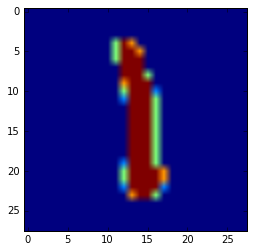

In [214]:
i = random.randint(0, 9) 
print(Y_train[i])
plt.imshow(X_train[i][:,:,0])

# Define the Data Augmentation


Based on [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6):

- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- No vertical_flip or horizontal_flip 


In [217]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Define the CNN models
All four of our different model architectures sharing some common attributes

In [215]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 86

img_rows, img_cols = 28, 28

nb_filters_1 = 32 
nb_filters_2 = 64 
nb_filters_3 = 128 

nb_conv = 3 # kernel_size dim
nb_classes = Y_train.shape[1]


## CNN Model #1:
Based on [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6). 

**Layer 1, 2, 5, 6:** convolutional (Conv2D) layer with nb_filters_1 (32) filters for 1&2 and nb_filters_2 (64) filters for 5&6. Each filter transforms a part of the image defined by the kernel size nb_conv (3) using the kernel filter. 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

**Layer 3, 7:** Each sequence of two convolution (Conv2D) layers os followed by the pooling (MaxPool2D) layer, which acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value (reduce computational cost, reduce overfitting). 

*Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.*

**Layer 4, 8, 11:** Each pooling layer is followed by dropout (Dropout), is a regularization method in which a random proportion of the nodes in a layer are randomly ignored by setting their wieghts to zero. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

**Layer 9:** The Flatten layer converts the final feature maps into a one single 1D vector. It combines all the found local features of the previous convolutional layers and makes it possible to use of fully connected layers after the convolutional/maxpool layers. 

**Layer 10, 12:** Finally, two fully-connected (Dense) layers which are just artificial an neural networks (ANN) classifiers. In the last layer(Dense(10,activation="softmax")), the net outputs distribution of probability of each class.


In [216]:
model1 = Sequential()
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(nb_classes, activation = "softmax"))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 7, 64)          0         
__________

# We Train & Pickle 3 model variants: 
- vanilla, 
- with LR annealing and 
- with LR nnealing and datauamentation

## CNN Model #2:
Based on [somshubramajumdar](https://www.kaggle.com/somshubramajumdar/deep-convolutional-network-using-keras). 

Same as Model #1 except we drop (!) both of the Dropout layers following the first and second set of Conv2D+Conv2D+MaxPool2D. Thefinal sequence of Flatten+Dense+Dropout+Dense is replaced by Flatten+Dropout+Dense+Dense. The second to last Dense layer's ouput space dim is half that of Model#1 (128 vesus 256). Also, adam is used as the update rule instead of RMSProp.

Comparing the accuracy of these two models, model 2 exhibits more overfitting but ultimately performs just as well as model 1. 


[*"in CNN, usually, a Dropout layer is applied after each pooling layer, and also after your Dense layer. A good tutorial is here"*](https://datascience.stackexchange.com/questions/22760/number-and-size-of-dense-layers-in-a-cnn)

In [166]:
model2 = Sequential()

model2.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model2.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(strides=(2,2)))

model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(128, activation = "relu"))
model2.add(Dense(nb_classes, activation = "softmax"))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 3136)              0         
__________

## CNN Model #3:
Based on [yashk2810.github]( https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/). 

A completely different architecture! We keep our individual **Conv2D** layers the same in terms of filters and kernel size values, but now instead for the padding parameter being 'Same', it is set to the default 'Valid'. Lastly, activation in these layers is set to the default of None, and only implemented after Batch Normalization. 

No longer are we stringing two Conv2D layers together. Instead, each Conv2D layer is followed by BatchNormalization and Activation, for a total of 4 sequences of Conv2D+BatchNormalization+Activation. 

**BatchNormalization**: performs normalization for each training mini-batch, allowing us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout. 

**Activation**: In previous models, this was incorporated intp the Conv2D layer but now, we save this for after BatchNormalization. It is debatable whether Activation should precede or follow BatchNormalization. 

After ever 2 sequences of Conv2D+BatchNormalization+Activation, we follow with a MaxPool2D of the same size as in the previous two models.

Finally, we wrap up with a sequence of Flatten+Dense+BatchNormalization+Activation and Dropout+Dense(nb_classes). Our Second to last dense layer's ouput space dim is twise that of Model#1 (512 vesus 256) and four times that of Model#2  (512 vesus 128).

Our optimizer is the same as in Model #2 - "Adam". 

Comparing the accuracy of these three models, model 3 exhibits similar behavior of model 2 -- more overfitting but ultimately performs (exactly!) just as well as model 1.  Could this be tied to using Adam instad of RMSProp? 

**Without data augmentation: After 30 epochs:** val_acc: 0.9919

In [218]:
model3 = Sequential()

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))                
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(Dropout(0.2))
model3.add(Dense(nb_classes, activation = "softmax"))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_32 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_33 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_33 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_34 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 12, 12, 32)        0         
__________

## CNN Model #4:

I tried adding BatchNormalization to the second model, between the convolution and activation layers. However, this did not really improve perfomance. 

Comparing the accuracy of these three models, model 4 exhibits similar behavior of model 2 & 4 -- more overfitting but ultimately has more volatily validation scores. 

**Without data augmentation: After 30 epochs:** val_acc:  0.9902

In [219]:
model4 = Sequential()

model4.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 input_shape = (28,28,1)))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2,2)))

model4.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(MaxPool2D(strides=(2,2)))

model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(128, activation = "relu"))
model4.add(Dense(nb_classes, activation = "softmax"))

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_37 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_38 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_38 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_39 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 14, 14, 32)        0         
__________

# Load the pickles

In [ ]:
history1_A = pickle.load( open( 'model1_history_30epochs_noLRred.p', 'rb'))
history1_B = pickle.load( open( 'model1_history_30epochs.p', 'rb'))
history1_C = pickle.load( open( 'model1_history_30epochs_wDAug.p', 'rb'))

history2_A = pickle.load( open( 'model2_history_30epochs_noLRred.p', 'rb'))
history2_B = pickle.load( open( 'model2_history_30epochs.p', 'rb'))
history2_C = pickle.load( open( 'model2_history_30epochs_wDAug.p', 'rb'))

history3_A = pickle.load( open( 'model3_history_30epochs_noLRred.p', 'rb'))
history3_B = pickle.load( open( 'model3_history_30epochs.p', 'rb'))
history3_C = pickle.load( open( 'model3_history_30epochs_wDAug.p', 'rb'))

history4_A = pickle.load( open( 'model4_history_30epochs_noLRred.p', 'rb'))
history4_B = pickle.load( open( 'model4_history_30epochs.p', 'rb'))
history4_C = pickle.load( open( 'model4_history_30epochs_wDAug.p', 'rb'))

#  Compare the validation scores across all variants for each arhcitecture

Of the first architecture, the highest validation score overall epochs was achieved by the **vanilla model** and the highest final epoch validation score was achieved by **(tied) both non-vanilla models**.

In [226]:
print ("Final Validation Score of Model 1_A: %f" % (history1_A['val_acc'][-1]))
print ("Final Validation Score of Model 1_B: %f" % (history1_B['val_acc'][-1]))
print ("Final Validation Score of Model 1_C: %f" % (history1_C['val_acc'][-1]))
print
print ("Best! Validation Score of Model 1_A: %f" % max(history1_A['val_acc']))
print ("Best! Validation Score of Model 1_B: %f" % max(history1_B['val_acc']))
print ("Best! Validation Score of Model 1_C: %f" % max(history1_C['val_acc']))


Final Validation Score of Model 1_A: 0.991905
Final Validation Score of Model 1_B: 0.992381
Final Validation Score of Model 1_C: 0.992381

Best! Validation Score of Model 1_A: 0.993810
Best! Validation Score of Model 1_B: 0.992857
Best! Validation Score of Model 1_C: 0.992857


Of the second architecture, the highest validation score overall epochs was achieved by the **LR annealing & data augmented model** and the highest final epoch validation score was achieved by **LR annealing & data augmented model**. 

In [227]:
print ("Final Validation Score of Model 2_A: %f" % (history2_A['val_acc'][-1]))
print ("Final Validation Score of Model 2_B: %f" % (history2_B['val_acc'][-1]))
print ("Final Validation Score of Model 2_C: %f" % (history2_C['val_acc'][-1]))
print
print ("Best! Validation Score of Model 2_A: %f" % max(history2_A['val_acc']))
print ("Best! Validation Score of Model 2_B: %f" % max(history2_B['val_acc']))
print ("Best! Validation Score of Model 2_C: %f" % max(history2_C['val_acc']))


Final Validation Score of Model 2_A: 0.990000
Final Validation Score of Model 2_B: 0.992381
Final Validation Score of Model 2_C: 0.993571

Best! Validation Score of Model 2_A: 0.993571
Best! Validation Score of Model 2_B: 0.992857
Best! Validation Score of Model 2_C: 0.995238


Of the third architecture, the highest validation score overall epochs was achieved by the **LR annealing & data augmented model** and the highest final epoch validation score was achieved by **LR annealing & data augmented model**. 

In [228]:
print ("Final Validation Score of Model 3_A: %f" % (history3_A['val_acc'][-1]))
print ("Final Validation Score of Model 3_B: %f" % (history3_B['val_acc'][-1]))
print ("Final Validation Score of Model 3_C: %f" % (history3_C['val_acc'][-1]))
print
print ("Best! Validation Score of Model 3_A: %f" % max(history3_A['val_acc']))
print ("Best! Validation Score of Model 3_B: %f" % max(history3_B['val_acc']))
print ("Best! Validation Score of Model 3_C: %f" % max(history3_C['val_acc']))


Final Validation Score of Model 3_A: 0.991905
Final Validation Score of Model 3_B: 0.994048
Final Validation Score of Model 3_C: 0.994762

Best! Validation Score of Model 3_A: 0.993333
Best! Validation Score of Model 3_B: 0.995000
Best! Validation Score of Model 3_C: 0.995952


Of the fourth architecture, the highest validation score overall epochs was achieved by the **LR annealing & data augmented model** and the highest final epoch validation score was achieved by **LR annealing & data augmented model**. 

In [229]:
print ("Final Validation Score of Model 4_A: %f" % (history2_A['val_acc'][-1]))
print ("Final Validation Score of Model 4_B: %f" % (history2_B['val_acc'][-1]))
print ("Final Validation Score of Model 4_C: %f" % (history2_C['val_acc'][-1]))
print
print ("Best! Validation Score of Model 4_A: %f" % max(history2_A['val_acc']))
print ("Best! Validation Score of Model 4_B: %f" % max(history2_B['val_acc']))
print ("Best! Validation Score of Model 4_C: %f" % max(history2_C['val_acc']))


Final Validation Score of Model 4_A: 0.990000
Final Validation Score of Model 4_B: 0.992381
Final Validation Score of Model 4_C: 0.993571

Best! Validation Score of Model 4_A: 0.993571
Best! Validation Score of Model 4_B: 0.992857
Best! Validation Score of Model 4_C: 0.995238


#  In every model architecture except the first one, 
## the models with the LR annealing and data augmentation performed significantly better.

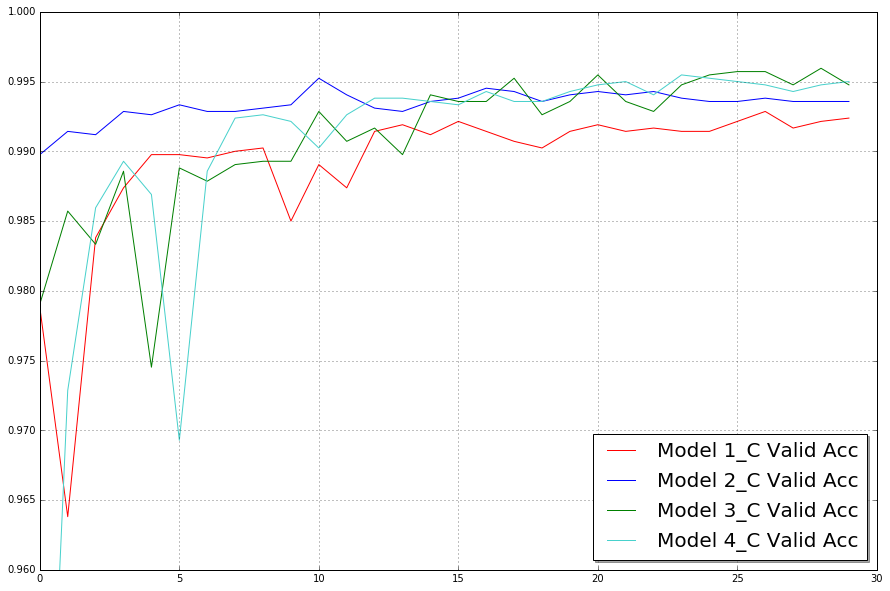

In [233]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.96)

plt.plot(history1_C['val_acc'], color='r',label="Model 1_C Valid Acc")
plt.plot(history2_C['val_acc'], color='b',label="Model 2_C Valid Acc")
plt.plot(history3_C['val_acc'], color='g',label="Model 3_C Valid Acc")
plt.plot(history4_C['val_acc'], color='mediumturquoise',label="Model 4_C Valid Acc")

plt.legend(loc=4, prop={'size': 20}, shadow=True, ncol=1)
plt.grid()

# Ultimately,
## the highest validation score is achieved by **Model 3-C at .99592**


# Finally, 
## let's output a submisison

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)